Analyses pre-registered for in-lab version of study 3a (reported in the submitted manuscript as study 3a).

Pre-registration: https://osf.io/de935

In [1]:
from __future__ import division
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import re
from scipy import stats
from pyspan.utils import *
from pyspan.plurals.analysis import *
assert not mturk
from pyspan.plurals.preprocess import *
from pyspan.plurals.utils import *

/Users/sabinasloman/Box/LoP/pyspan/pyspan/config.py:19: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/sabinasloman/.pyenv/versions/2.7.17/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/sabinasloman/.pyenv/versions/2.7.17/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  

## Demographics

In [2]:
valence_raw = pd.read_csv("{}in-lab/Valence.csv".format(BASE_DIR))
len(valence_raw), len(valence)

(196, 160)

In [3]:
demographic_info(valence)

Age: 24.2484076433 (SE = 0.707491009538)
Gender: [('Both', 1), ('Female', 105), ('Male', 51)]


## Logistic regression

Selection of plural ~ Valence of item + Condition + Valence of item * Condition + Dummy indicating whether or not this was the first survey the participant took (including participant-level effects)

We hypothesize that the coefficient on Valence of item * Condition will be positive. We will commit to throwing out all data from the valence survey by participants who did not take the survey first if the order dummy has a non-zero coefficient.

In [4]:
vdummied, Y = dummy(valence, classes = [ "POSITIVE", "NEGATIVE" ],
                    sets = np.stack((words["large"], words["small"])))

In [5]:
def valence_condition_interaction(v, c):
    c = c if c == 1 else -1
    return v*c
valence_condition_interaction = np.vectorize(valence_condition_interaction)
X, Y = df_to_matrix(vdummied, Y,
                    columns = { 0: "valence", 1: "condition", 
                                2: (0,1,valence_condition_interaction), 
                                3: "order" })

In [6]:
logit = SparseLR(Y, X); print logit.coef[:4]; print logit.auc

/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[ 0.07595854 -0.21906912  0.44167228  0.        ]
0.7361603523651272


## t-tests

For each participant, compute the proportion of positive items for which the participant chose the pluralized form of the word, the proportion of neutral items for which the participant chose the pluralized form of the word, and the proportion of negative items for which the participant chose the pluralized form of the word.

In [7]:
vsummary = valence[["Condition"]]
dat = valence[ixs].values
vsummary["pos_lg"] = np.apply_along_axis(get_prop, 1, dat,
                                         cats["pos_lg"], 
                                         cats["pos_sm"])
vsummary["neu_lg"] = np.apply_along_axis(get_prop, 1, dat,
                                         cats["neu_lg"], 
                                         cats["neu_sm"])
vsummary["neg_lg"] = np.apply_along_axis(get_prop, 1, dat,
                                         cats["neg_lg"], 
                                         cats["neg_sm"])
assert vsummary.values.shape == (len(valence), 4)

/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

### Positive condition

Hypothesis: mean(% pluralized positive items chosen) - mean(% pluralized neutral items chosen) > 0

In [8]:
a = vsummary.loc[vsummary["Condition"] == "POSITIVE"]["pos_lg"].values
b = vsummary.loc[vsummary["Condition"] == "POSITIVE"]["neu_lg"].values
delta = np.mean(a) - np.mean(b)
stats.ttest_rel(a, b)

Ttest_relResult(statistic=7.106372535961273, pvalue=3.9864208196530896e-10)

Hypothesis: mean(% pluralized negative items chosen) - mean(% pluralized neutral items chosen) < 0

In [9]:
a = vsummary.loc[vsummary["Condition"] == "POSITIVE"]["neg_lg"].values
b = vsummary.loc[vsummary["Condition"] == "POSITIVE"]["neu_lg"].values
delta = np.mean(a) - np.mean(b)
stats.ttest_rel(a, b)

Ttest_relResult(statistic=-13.310134230600777, pvalue=3.420205000461316e-22)

### Negative condition

Hypothesis: mean(% pluralized negative items chosen) - mean(% pluralized neutral items chosen) > 0

In [10]:
a = vsummary.loc[vsummary["Condition"] == "NEGATIVE"]["neg_lg"]
b = vsummary.loc[vsummary["Condition"] == "NEGATIVE"]["neu_lg"]
delta = np.mean(a) - np.mean(b)
stats.ttest_rel(a, b)

Ttest_relResult(statistic=9.80194617958375, pvalue=3.941789027276109e-15)

Hypothesis: mean(% pluralized positive items chosen) - mean(% pluralized neutral items chosen) < 0

In [11]:
a = vsummary.loc[(vsummary["Condition"] == "NEGATIVE") & 
                 (~np.isnan(vsummary["pos_lg"]))]["pos_lg"].values
b = vsummary.loc[(vsummary["Condition"] == "NEGATIVE") & 
                 (~np.isnan(vsummary["pos_lg"]))]["neu_lg"].values
delta = np.mean(a) - np.mean(b)
stats.ttest_rel(a, b)

Ttest_relResult(statistic=-5.897654542241425, pvalue=9.907220563537141e-08)

### Combining conditions

Recode observations in the negative condition to be the opposite of what participants chose.

In [12]:
vpos = vsummary.loc[vsummary["Condition"] == "POSITIVE"]
vneg = vsummary.loc[vsummary["Condition"] == "NEGATIVE"]
vneg["pos_lg"] = 1 - vneg["pos_lg"]
vneg["neu_lg"] = 1 - vneg["neu_lg"]
vneg["neg_lg"] = 1 - vneg["neg_lg"]
vrecoded = pd.concat([ vpos, vneg ])
assert len(vrecoded) == len(vpos) + len(vneg)

/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWi

Hypothesis: mean(% pluralized positive items chosen) - mean(% pluralized neutral items chosen) > 0

In [13]:
a = vrecoded.loc[~np.isnan(vrecoded["pos_lg"])]["pos_lg"].values
b = vrecoded.loc[~np.isnan(vrecoded["pos_lg"])]["neu_lg"].values
delta = np.mean(a) - np.mean(b)
stats.ttest_rel(a, b)

Ttest_relResult(statistic=9.23177952151807, pvalue=1.6745675245674523e-16)

Compute degrees of freedom.

In [14]:
len(a) - 1

158

In [15]:
cohensd(a, b)

0.5639049692108862

Hypothesis: mean(% pluralized negative items chosen) - mean(% pluralized neutral items chosen) < 0

In [16]:
a = vrecoded["neg_lg"].values
b = vrecoded["neu_lg"].values
delta = np.mean(a) - np.mean(b)
stats.ttest_rel(a, b)

Ttest_relResult(statistic=-16.071520212170554, pvalue=3.881668223982871e-35)

Compute degrees of freedom.

In [17]:
len(a) - 1

159

In [18]:
cohensd(b, a)

1.758990312011117

Figure 2a

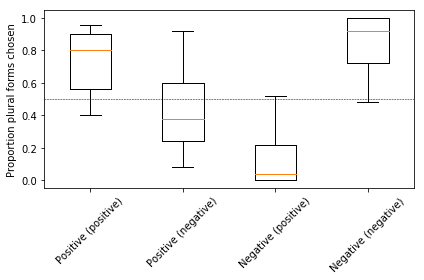

In [19]:
fig, ax = plt.subplots(1)
x_pp = vsummary.loc[vsummary["Condition"] == "POSITIVE"]["pos_lg"].values
x_pn = vsummary.loc[vsummary["Condition"] == "POSITIVE"]["neg_lg"].values
x_np = vsummary.loc[vsummary["Condition"] == "NEGATIVE"]["pos_lg"].values
x_np = x_np[~np.isnan(x_np)]
x_nn = vsummary.loc[vsummary["Condition"] == "NEGATIVE"]["neg_lg"].values
ax.boxplot([ x_pp, x_np, x_pn, x_nn ], whis = [5,95], sym = "")
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
ax.plot(xlim, [.5,.5], color = "k", linestyle = "--", linewidth = .5)
ax.set_ylabel("Proportion plural forms chosen")
ax.set_xticklabels([ "Positive (positive)", "Positive (negative)",
                     "Negative (positive)", 
                     "Negative (negative)" ], rotation = 45)
plt.tight_layout()